In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib
import tables            as tb
import random
import glob
import warnings
sns.set()

from  invisible_cities.io.dst_io              import load_dsts
from  invisible_cities.core .core_functions   import in_range
from  invisible_cities.core.system_of_units_c import units
import invisible_cities.reco.corrections      as corrf

from krcal.core.io_functions       import kdst_write
from krcal.core.io_functions       import filenames_from_list
from krcal.core.io_functions       import write_maps
from krcal.core.io_functions       import read_maps
from krcal.core.io_functions       import write_maps_ts
from krcal.core.io_functions       import read_maps_ts

from krcal.core.histo_functions    import h1, h1d, h2, h2d, plot_histo

from krcal.core.core_functions      import time_delta_from_time
from krcal.core.core_functions      import phirad_to_deg
from krcal.core.core_functions      import NN
from krcal.core.core_functions      import timeit
from krcal.core                     import fit_functions_ic as fitf

from krcal.core.plt_functions  import plot_sector
from krcal.core.plt_functions  import plot_sectors

from krcal.core.stat_functions      import mean_and_std

from krcal.core.analysis_functions  import kr_ranges_and_bins
from krcal.core.analysis_functions  import fiducial_volumes
from krcal.core.analysis_functions  import fid_eff
from krcal.core.analysis_functions  import select_rphi_sectors
from krcal.core.analysis_functions  import select_xy_sectors
from krcal.core.analysis_functions  import event_map

from krcal.core.analysis_functions  import kr_event_selection
from krcal.core.analysis_functions  import kr_event

from krcal.core.fit_lt_functions    import fit_lifetime
from krcal.core.fit_lt_functions    import time_fcs
from krcal.core.fit_lt_functions    import fit_fcs_in_rphi_sectors
from krcal.core.fit_lt_functions    import fit_fcs_in_xy_bin
from krcal.core.fit_lt_functions    import fit_map_rphi
from krcal.core.fit_lt_functions    import fit_map_xy
from krcal.core.fit_lt_functions    import get_time_series

from krcal.core.fit_lt_histograms   import histo_fit_sectors
from krcal.core.fit_lt_histograms   import print_fit_sectors_pars
from krcal.core.fit_lt_histograms   import plot_fit_sectors
from krcal.core.fit_lt_histograms   import plot_fit_xy
from krcal.core.fit_lt_histograms   import plot_time_fcs
from krcal.core.fit_lt_histograms   import plot_fit_lifetime_and_chi2
from krcal.core.fit_lt_histograms   import print_fit_lifetime

from krcal.core.fit_energy_functions    import fit_energy
from krcal.core.fit_energy_functions    import plot_fit_energy
from krcal.core.fit_energy_functions    import print_fit_energy
from krcal.core.fit_energy_functions    import resolution_r_z
from krcal.core.fit_energy_functions    import plot_resolution_r_z

from krcal.core.kr_types import PlotLabels, KrEvent, ASectorMap
from krcal.core.kr_types import FitType, KrSector, MapType
from krcal.core.kr_types import KrFileName
from krcal.core.kr_types import ASectorMap

from krcal.core.rphi_maps_functions   import draw_rphi_maps
from krcal.core.rphi_maps_functions   import draw_rphi_map
from krcal.core.rphi_maps_functions   import draw_rphi_maps_ts
from krcal.core.rphi_maps_functions   import draw_wedges
from krcal.core.rphi_maps_functions   import define_rphi_sectors
from krcal.core.rphi_maps_functions   import rphi_sector_map_def

from krcal.core.map_functions   import tsmap_from_fmap
from krcal.core.map_functions   import amap_from_tsmap
from krcal.core.map_functions   import relative_errors
from krcal.core.map_functions   import amap_valid_mask
from krcal.core.map_functions   import amap_valid_fraction
from krcal.core.map_functions   import amap_average
from krcal.core.map_functions   import amap_max
from krcal.core.map_functions   import amap_min
from krcal.core.map_functions   import amap_replace_nan_by_mean
from krcal.core.map_functions   import amap_replace_nan_by_zero
from krcal.core.map_functions   import regularize_maps
from krcal.core.map_functions   import get_maps_from_tsmap
from krcal.core.map_functions   import map_average
from krcal.core.map_functions   import add_mapinfo

from krcal.core.xy_maps_functions   import draw_xy_maps
from krcal.core.xy_maps_functions   import draw_xy_map
from krcal.core.xy_maps_functions   import draw_xy_maps_ts

from krcal.core.s1s2_functions  import energy_time_profile
from krcal.core.s1s2_functions  import energy_X_profile

from krcal.core.correction_functions import e0_rphi_correction
from krcal.core.correction_functions import e0_xy_correction
from krcal.core.correction_functions import lt_xy_correction
from krcal.core.correction_functions import e0_xy_correction_ts
from krcal.core.correction_functions import lt_xy_correction_ts
from krcal.core.correction_functions import lt_rphi_correction
from krcal.core.correction_functions import lt_rphi_correction_ts

import krcal.dev.corrections       as corrections 

from numpy import pi, sqrt

from typing      import List, Tuple, Dict, Sequence, Iterable

from ipywidgets import interact, interactive, fixed
from IPython.display import display

import matplotlib.pyplot as plt
from krcal.core.kr_types import KrFileName

Importing the function for the time evolution

In [2]:
from krcal.core.kr_parevol_functions import kr_time_evolution

Dst file opening and selecting kr events

In [3]:
input_path  = f"$IC_DATA/dst"
output_path = f"$IC_DATA/ldst"
map_path    = f"$IC_DATA/maps"

run_number  = 6573
input_file_names  = [f'dst_{run_number}_trigger1_0000_6679.h5']

time_bins = 25
output_file_name  = ' '
map_file_name     = ''
map_file_name_ts  = ''
emap_file_name    = f'kr_emap_xy_100_100_r_{run_number}.h5'


krfn = KrFileName(input_file_names,
                  output_file_name,
                  map_file_name,
                  map_file_name_ts,
                  emap_file_name)
fn =filenames_from_list(krfn, input_path, output_path, map_path)

In [4]:
dst           = load_dsts(fn.input_file_names, "DST", "Events")
t0            = dst.time.min()
unique_events = ~dst.event.duplicated()
number_of_evts_full = np.count_nonzero(unique_events)

print(f"Total number of events: {len(dst)}")

Total number of events: 2596957


In [5]:
dst_time = dst.sort_values('time')
T       = dst_time.time.values
DT      = time_delta_from_time(T)

In [6]:
RMAX      = 200
RCORE     = 100
s1e_range = (3, 25)
s2e_range = (2000, 14000)
s2q_range = (200, 800)

xy_range  = (-RMAX,  RMAX)
z_range   = (10,  550)
e_range = (5000, 14000)
lt_range = (1000, 6000)
c2_range = (0,5)

krTimes, krRanges, krNbins, krBins = kr_ranges_and_bins(dst,
                                                        xxrange   = xy_range,
                                                        yrange    = xy_range,
                                                        zrange    = z_range,
                                                        s2erange  = s2e_range,
                                                        s1erange  = s1e_range,
                                                        s2qrange  = s2q_range,
                                                        xnbins    = 100,
                                                        ynbins    = 100,
                                                        znbins    = 15,
                                                        s2enbins  = 25,
                                                        s1enbins  = 10,
                                                        s2qnbins  = 25,
                                                        tpsamples = 3600) # tsamples in seconds

In [7]:
dst = dst[dst.R<100]


dst_time = dst.sort_values('event')
T       = dst_time.time.values
DT      = time_delta_from_time(T)

In [8]:
kge = kr_event(dst, DT, dst.S2e, dst.S2q) 

Making time slices and list of masks

In [9]:
ti = timeit(get_time_series)
ts, masks = ti(time_bins, (DT[0],DT[-1]), kge)

Time spent in get_time_series: 0.13191008567810059 s


Reading correction map

In [10]:
emaps = read_maps(filename=fn.emap_file_name)

Applying the function for parameters evolution

In [11]:
ti = timeit(kr_time_evolution)
pars = ti(ts+t0, masks, dst, emaps, xr_map=krRanges.X, yr_map=krRanges.Y, nx_map=krNbins.X, ny_map=krNbins.X)

Time spent in kr_time_evolution: 124.6180830001831 s


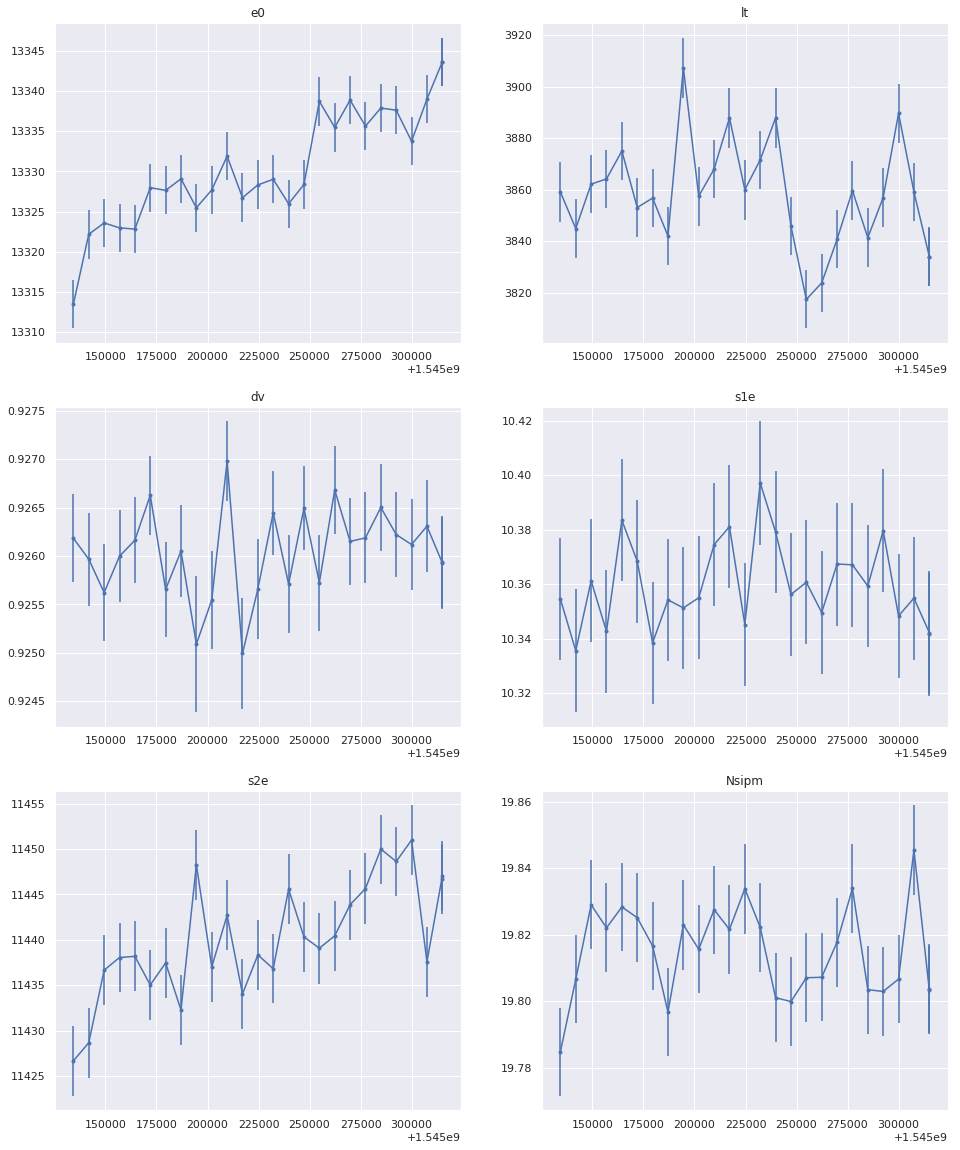

In [12]:
plt.figure(figsize=(16, 20));
plt.subplot(3,2,1);
plt.title('e0');
plt.errorbar(pars.ts, pars.e0, pars.e0u, fmt='.', linestyle='-');
plt.subplot(3,2,2);
plt.title('lt');
plt.errorbar(pars.ts, pars['lt'], pars['ltu'], fmt='.', linestyle='-');
plt.subplot(3,2,3);
plt.title('dv');
#plt.ylim(0.925, 0.9275);
plt.errorbar(pars.ts, pars.dv, pars.dvu, fmt='.', linestyle='-');
plt.subplot(3,2,4);
plt.title('s1e');
plt.errorbar(pars.ts, pars.s1e, pars.s1eu, fmt='.', linestyle='-');
plt.subplot(3,2,5);
plt.title('s2e');
plt.errorbar(pars.ts, pars.s2e, pars.s2eu, fmt='.', linestyle='-');
plt.subplot(3,2,6);
plt.title('Nsipm');
plt.errorbar(pars.ts, pars.Nsipm, pars.Nsipmu, fmt='.', linestyle='-');

### Saving time parameters evolution

In [13]:
pars.to_hdf('/home/ausonandres/KrCalibNB/maps/kr_emap_xy_100_100_r_6573_time.h5', key='time_evolution', mode='a')

### Opening table again

In [14]:
test_pars = pd.read_hdf('/home/ausonandres/KrCalibNB/maps/kr_emap_xy_100_100_r_6573_time.h5', key='time_evolution')

In [15]:
test_pars

,ts,e0,e0u,lt,ltu,dv,dvu,s1w,s1wu,s1h,...,s2e,s2eu,s2q,s2qu,Nsipm,Nsipmu,Xrms,Xrmsu,Yrms,Yrmsu
0,1.545134e+09,13313.485612,3.018015,3859.072899,11.510333,0.926184,0.000456,186.488744,0.420710,2.002748,...,11426.667674,3.847295,581.377524,0.340188,19.784822,0.013229,12.244289,0.031166,12.276438,0.031360
1,1.545142e+09,13322.187624,3.029075,3844.872298,11.392885,0.925967,0.000481,186.853677,0.424269,1.997534,...,11428.666401,3.858114,581.946570,0.342113,19.806589,0.013236,12.332204,0.031481,12.384591,0.031638
2,1.545149e+09,13323.593343,2.965769,3862.124487,11.348939,0.925623,0.000499,187.210896,0.422410,1.997571,...,11436.658349,3.852028,582.302650,0.342318,19.829040,0.013399,12.266953,0.031133,12.390852,0.031904
3,1.545157e+09,13322.979201,3.015349,3864.140287,11.408675,0.925998,0.000475,186.952367,0.422075,1.992016,...,11438.056087,3.856344,582.116099,0.342022,19.822111,0.013427,12.335412,0.031618,12.375336,0.031995
4,1.545164e+09,13322.820951,2.978115,3874.984835,11.420681,0.926163,0.000445,187.834862,0.422048,1.998092,...,11438.180943,3.854107,582.333483,0.342042,19.828383,0.013324,12.377204,0.031547,12.422231,0.031919
5,1.545172e+09,13327.986537,3.000973,3853.037555,11.344446,0.926627,0.000406,187.807922,0.423312,1.993396,...,11435.031478,3.856672,581.403215,0.341060,19.825177,0.013304,12.260419,0.031003,12.408620,0.032070
6,1.545179e+09,13327.644203,2.985135,3856.710995,11.282536,0.925655,0.000487,187.075293,0.420095,1.995152,...,11437.459543,3.830017,581.942592,0.339463,19.816672,0.013333,12.331787,0.031382,12.363693,0.031524
7,1.545187e+09,13329.079942,3.014723,3841.951248,11.292225,0.926051,0.000478,187.197828,0.420574,1.996140,...,11432.275626,3.821789,581.087928,0.337727,19.796760,0.013267,12.275852,0.030832,12.328247,0.031463
8,1.545195e+09,13325.481348,3.016334,3907.291035,11.718345,0.925090,0.000702,186.823061,0.423100,1.999538,...,11448.268695,3.839066,582.170466,0.341025,19.823024,0.013470,12.298750,0.031461,12.349713,0.032007
9,1.545202e+09,13327.698188,3.005562,3857.441843,11.421376,0.925545,0.000505,187.521944,0.425416,1.997164,...,11437.009250,3.853766,581.942385,0.342573,19.815668,0.013263,12.277360,0.031225,12.360078,0.031595


### Plotting some parameters again to crosscheck

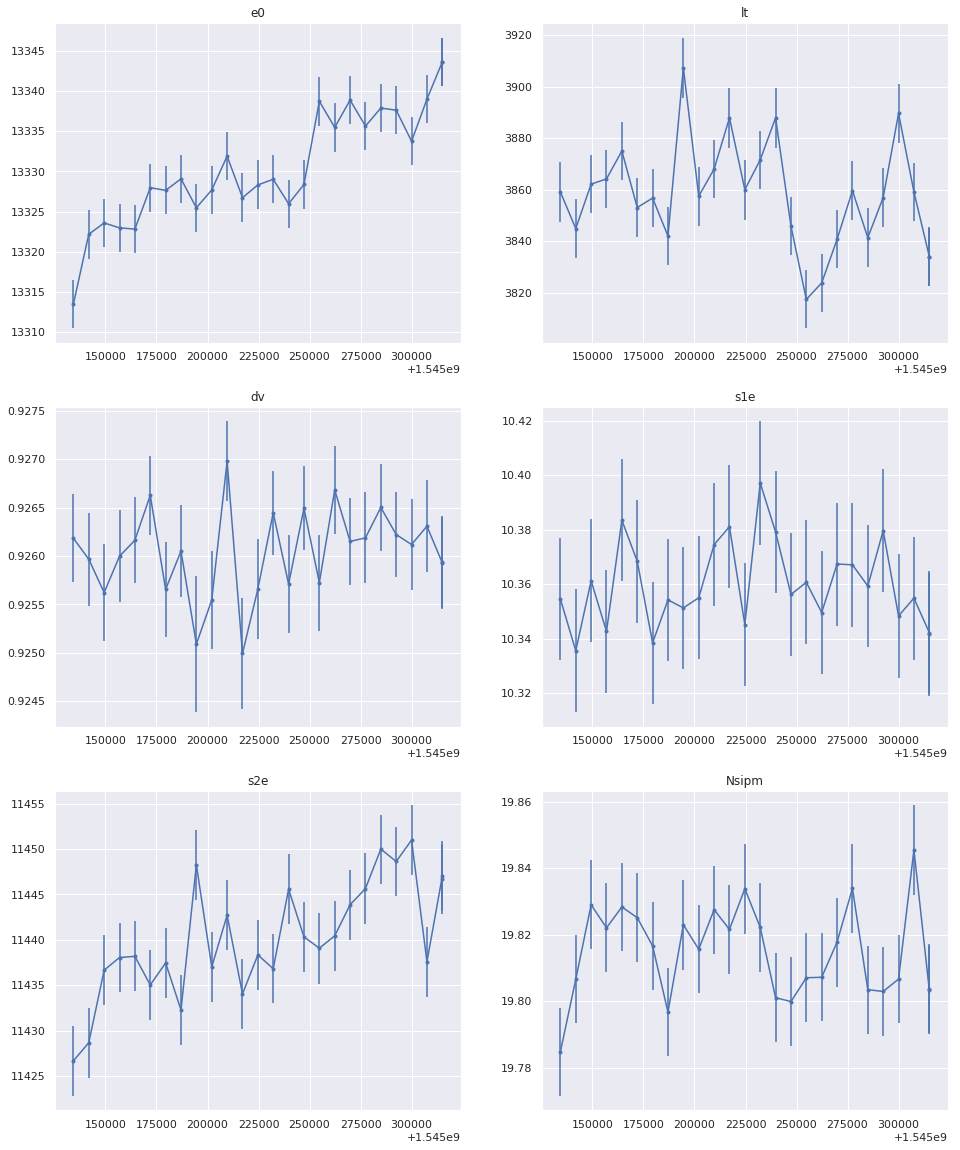

In [16]:
plt.figure(figsize=(16, 20));
plt.subplot(3,2,1);
plt.title('e0');
plt.errorbar(test_pars.ts, test_pars.e0, test_pars.e0u, fmt='.', linestyle='-');
plt.subplot(3,2,2);
plt.title('lt');
plt.errorbar(test_pars.ts, test_pars['lt'], test_pars['ltu'], fmt='.', linestyle='-');
plt.subplot(3,2,3);
plt.title('dv');
#plt.ylim(0.925, 0.9275);
plt.errorbar(test_pars.ts, test_pars.dv, test_pars.dvu, fmt='.', linestyle='-');
plt.subplot(3,2,4);
plt.title('s1e');
plt.errorbar(test_pars.ts, test_pars.s1e, test_pars.s1eu, fmt='.', linestyle='-');
plt.subplot(3,2,5);
plt.title('s2e');
plt.errorbar(test_pars.ts, test_pars.s2e, test_pars.s2eu, fmt='.', linestyle='-');
plt.subplot(3,2,6);
plt.title('Nsipm');
plt.errorbar(test_pars.ts, test_pars.Nsipm, test_pars.Nsipmu, fmt='.', linestyle='-');